In [14]:
from lib.data import *
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps
import economic_complexity as ecplx
#from informe import SimuladorEstatico, SimuladorDinamico, SimuladorComplejo, PaisNaive
from informe import *
from lib.utils import correr_simulacion_mostrando, cantidad_descubrimientos_iteracion
import numpy as np

data, raw = get_default_oec_rca_raw_data()

Se cargaron los datos desde ../data/default_oce_2018-2020.pkl


In [15]:
rca = ecplx.rca(data)
M = build_M_from(rca)

In [16]:
cigarras = SimuladorComplejo(lambda step: step > 25, PaisCigarra, M.copy(deep=True), 0.1)
hormigas = SimuladorComplejo(lambda step: step > 25, PaisHormiga, M.copy(deep=True), 0.1)

grafo_inicial = cigarras.grafo( )
PCI_inicial = cigarras.PCI.copy( deep=True )

historia_cigarras = correr_simulacion_mostrando(cigarras, False)
historia_hormigas = correr_simulacion_mostrando(hormigas, False)

proximidad calculada en: 0.17640137672424316
paises creados en: 0.013036966323852539
proximidad calculada en: 0.18012642860412598
paises creados en: 0.01401376724243164
empezando simulación: 2024-07-01 13:58:28
empezando simulación: 2024-07-01 13:59:08


In [10]:
from lib.utils import savefig

def plot_grafo_estatico( res_iteracion, G, PCI, country_name, cmap='Reds'):
    cm = colormaps[ cmap ]
    PCI -= np.min( PCI )
    PCI /= np.max(PCI)
    PCI = (20 * PCI) ** 2

    pos = nx.spring_layout(G, dim=2, k=1.3)
    nx.draw(G, pos, with_labels=False, node_color='white',  edgecolors='gray', node_size=PCI.values, width=0.01, edgelist=[] )

    productos_iniciales = M.loc[country_name]
    productos_iniciales = productos_iniciales[productos_iniciales == 1].index.to_list()

    nx.draw_networkx_nodes(G, pos, 
        nodelist=productos_iniciales, 
        node_color='#cccccc', 
        node_size=PCI.loc[productos_iniciales].values, edgecolors='gray')

    for iteracion in range( 0,len(res_iteracion)):
        nodos_exportados = res_iteracion[iteracion][country_name]

        nx.draw_networkx_nodes(G, pos, 
                               nodelist=nodos_exportados, 
                               node_color=np.array(list(cm(iteracion / len(res_iteracion))))[:3].reshape(1,-1), 
                               node_size=PCI.loc[nodos_exportados].values, edgecolors='gray')
        
    if np.array_equal(res_iteracion, historia_cigarras):
        plt.title(country_name, loc='left', fontsize=16, y=1.02)  
        plt.suptitle('Cigarra', fontsize=14, x=0, y=1.03, ha='left', va='top')
        estrategia="cigarra"
    elif np.array_equal(res_iteracion, historia_hormigas):
        plt.title(country_name, loc='left', fontsize=16, y=1.02)  
        plt.suptitle('Hormiga', fontsize=14, x=0, y=1.03, ha='left', va='top')
        estrategia="hormiga"
    savefig(plt,f"grafo-{estrategia}_{country_name}")
    plt.show()


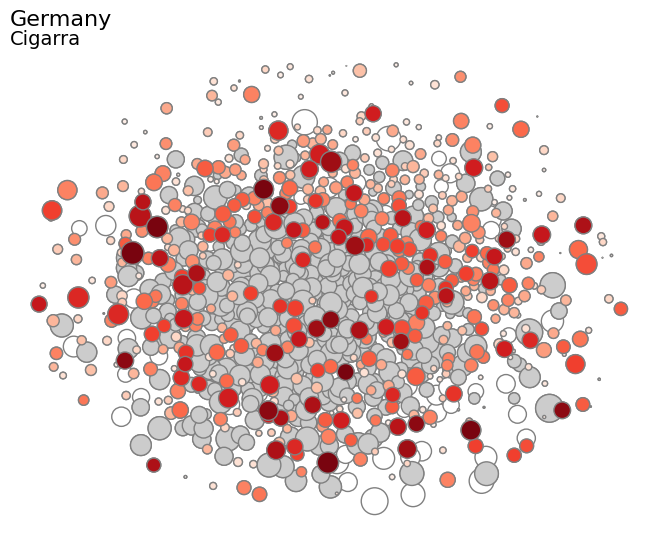

In [11]:
plot_grafo_estatico( historia_cigarras, grafo_inicial.copy(), PCI_inicial.copy(), 'Germany', 'Reds')

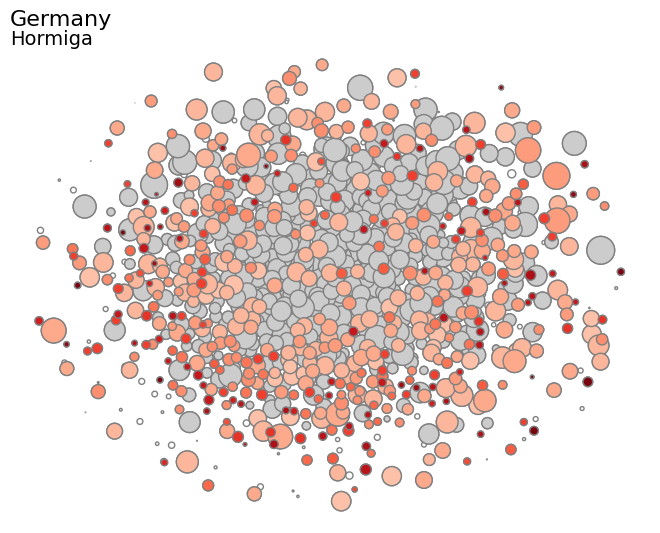

In [12]:
plot_grafo_estatico( historia_hormigas, grafo_inicial.copy(), PCI_inicial.copy(), 'Germany', 'Reds' )

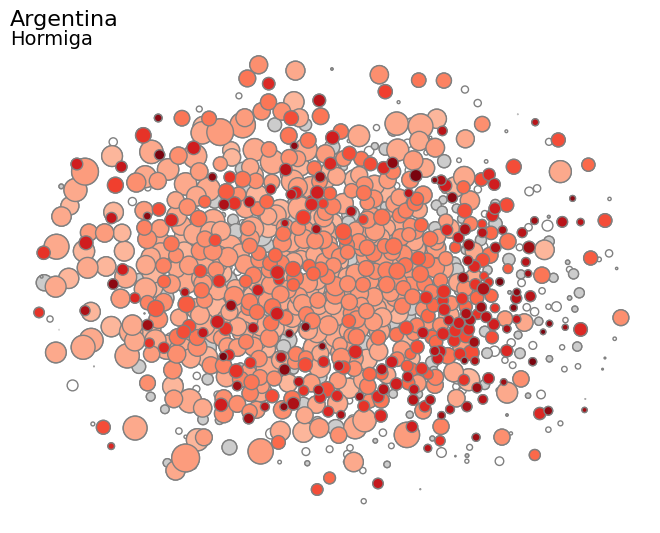

In [13]:
plot_grafo_estatico( historia_hormigas, grafo_inicial.copy(), PCI_inicial.copy(), 'Argentina', 'Reds' )

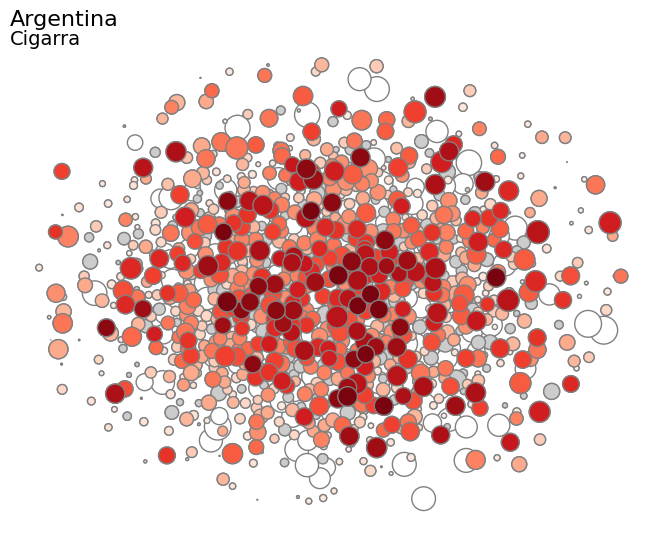

In [14]:
plot_grafo_estatico( historia_cigarras, grafo_inicial.copy(), PCI_inicial.copy(), 'Argentina', 'Reds' )

In [17]:
#A partir de aca se grafican los ECI para ciertos paises
from lib.data import *
from informe import *
from lib.utils import *
from lib.simulador import SimuladorComplejo

def epoch_2_date_str(epoch):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))


def graficar_cambio_clave(lista_diccionarios, claves, estrategia):
    
    colores = ['b', 'orange', 'g', 'r', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']  # Lista de colores
    
    plt.figure(figsize=(10, 6))
    
    for idx, clave in enumerate(claves):
        valores = [diccionario.get(clave, 0) for diccionario in lista_diccionarios]
        iteraciones = range(1, len(lista_diccionarios) + 1)
        
        color = colores[idx % len(colores)]  # Asignar un color de la lista, utilizando el índice con módulo para repetir si hay más claves que colores
        
        plt.plot(iteraciones, valores, marker='o', linestyle='-', color=color, label=clave)
    
    plt.title("Economic Complexity Index")
    
    # Corrección del if-elif-else
    if estrategia == "hormiga":
        plt.suptitle("Hormiga", fontsize=12)
    elif estrategia == "cigarra":
        plt.suptitle("Cigarra", fontsize=12)
    
    plt.xlabel('Iteration')
    plt.ylabel('ECI')
    plt.grid(True)
    plt.legend()
    
    # Agregar la fuente
    fuente_texto = 'Fuente: Propia'
    plt.figtext(0.99, 0.01, fuente_texto, ha='right', fontsize=10, color='gray')
    
    plt.tight_layout()
    savefig(plt, f"evolucion-eci-cuatro-paises-{estrategia}.png")
    plt.show()

In [18]:
from typing import List, Dict
import time

def correr_simulacion_mostrando_eci(sim, mostrar=True) -> List[Dict[str, float]]:
    """
    Run the simulation while displaying progress and return the economic complexity
    index (ECI) of each country for each iteration.
    """
    resultados_eci = []  
    start = time.time()

    print(f"Empezando simulación: {epoch_2_date_str(start)}", mostrar)  

    
    for _ in sim.iterar_simulacion():
        eci_actual = {}

       
        for pais in sim._paises.values():
            eci_actual[pais.country_name] = pais.mi_eci

        resultados_eci.append(eci_actual)

        
        if mostrar:
            for country, eci in eci_actual.items():
                print(f"{country}: ECI={eci}", mostrar)  

    
    if mostrar:
        print(f"Tiempo total de simulación: {time.time() - start} segundos", mostrar)

    return resultados_eci
cigarras = SimuladorComplejo(lambda step: step > 25, PaisCigarra, M.copy(deep=True), 0.4)
hormigas = SimuladorComplejo(lambda step: step > 25, PaisHormiga, M.copy(deep=True), 0.4)
resultados_cigarras = correr_simulacion_mostrando_eci(cigarras)
resultados_hormigas = correr_simulacion_mostrando_eci(hormigas)

proximidad calculada en: 0.17510628700256348
paises creados en: 0.014039278030395508
proximidad calculada en: 0.16889667510986328
paises creados en: 0.014754056930541992
Empezando simulación: 2024-07-01 14:00:17 True
Afghanistan: ECI=-1.162930111600457 True
Albania: ECI=-0.4149571282140224 True
Algeria: ECI=-1.139252940254259 True
Angola: ECI=-1.097947104453432 True
Argentina: ECI=-0.19905244606988076 True
Armenia: ECI=-0.16155902241838055 True
Australia: ECI=-0.5954923761399148 True
Austria: ECI=1.7681754780893484 True
Azerbaijan: ECI=-0.9853709615386047 True
Bahamas: ECI=0.572905230805001 True
Bahrain: ECI=0.41081756838742417 True
Bangladesh: ECI=-0.9064567882842173 True
Belarus: ECI=0.8968692066844286 True
Belgium: ECI=1.2912913335174312 True
Benin: ECI=-0.5553993693613668 True
Bolivia: ECI=-1.012159666410946 True
Bosnia and Herzegovina: ECI=0.5357708764035315 True
Botswana: ECI=-0.9950341689224768 True
Brazil: ECI=0.2348134045598231 True
Brunei: ECI=0.7133403567890847 True
Bulgaria

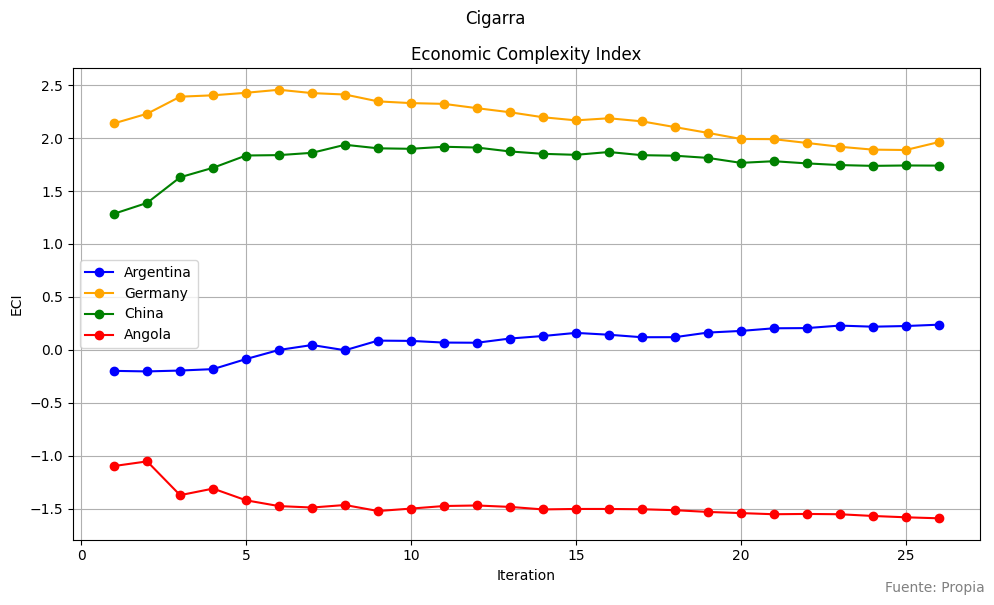

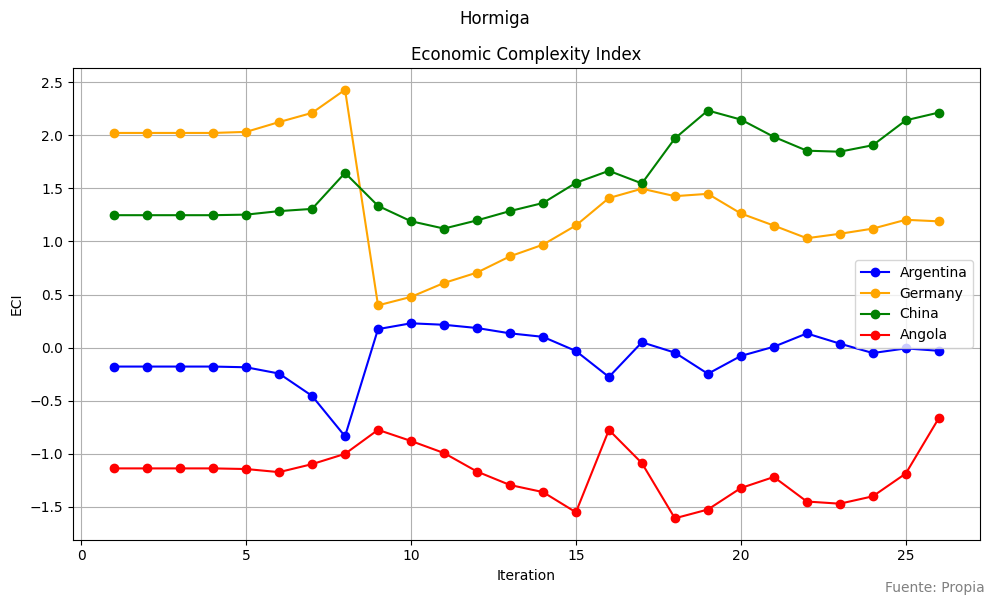

In [19]:
graficar_cambio_clave(resultados_cigarras,["Argentina","Germany","China","Angola"],"cigarra")
graficar_cambio_clave(resultados_hormigas,["Argentina","Germany","China","Angola"],"hormiga")